In [49]:
# core
import os, sys
from typing import Iterable, Dict, List, Callable, Tuple, Union, List

# third party
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, default_collate
import torch.nn.functional as F
from torchmetrics import SpearmanCorrCoef, AUROC
from sklearn.covariance import LedoitWolf #
# custom
sys.path.append('../')
from dataset import (
    ACDCDataset, 
    MNMDataset)
from model.unet import UNet2D, UNetEnsemble
from model.ae import AE
from model.wrapper import Frankenstein
from losses import DiceScoreCalgary, DiceScoreMMS #
from utils import UMapGenerator


In [3]:
### Data - M&M only
### - datasets
debug = False
batch_size = 1
test_vendor = 'A'

loader = {}
# - ACDC train
acdc_train = ACDCDataset(data='train', debug=debug)
acdc_train_loader = DataLoader(acdc_train, batch_size=batch_size, shuffle=False, drop_last=False)
loader['train'] = acdc_train_loader
# - ACDC val
acdc_val = ACDCDataset(data='val', debug=debug)
acdc_val_loader = DataLoader(acdc_val, batch_size=batch_size, shuffle=False, drop_last=False)
loader['val'] = acdc_val_loader
# - M&M A
mnm_a = MNMDataset(vendor=test_vendor, debug=debug)
mnm_a_loader = DataLoader(mnm_a, batch_size=batch_size, shuffle=False, drop_last=False)
loader['test'] = mnm_a_loader



loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties


In [4]:
### Model
# segmentation distortion, gonzales
# - path
root = '../../'
# U-Nets
middle = 'unet8_' 
pre = 'acdc'   
unet_name = f'{pre}_{middle}{0}'

model_path = f'{root}pre-trained-tmp/trained_UNets/{unet_name}_best.pt'
state_dict = torch.load(model_path)['model_state_dict']
n_chans_out = 4 
unet = UNet2D(n_chans_in=1, 
              n_chans_out=n_chans_out, 
              n_filters_init=8, 
              dropout=False)
unet.load_state_dict(state_dict)
unet.cuda()


# - instantiate transformations
layer_ids = ['shortcut0', 'shortcut1', 'shortcut2', 'up3']
disabled_ids = ['shortcut0', 'shortcut1', 'shortcut2']

                   #    channel, spatial, latent,  depth, block 
ae_map   = {'up3': [        64,      32,    128,     2,      4]}


AEs = nn.ModuleDict({'up3': AE(in_channels = ae_map['up3'][0], 
                                    in_dim      = ae_map['up3'][1],
                                    latent_dim  = ae_map['up3'][2],
                                    depth       = ae_map['up3'][3],
                                    block_size  = ae_map['up3'][4])})

for layer_id in disabled_ids:
     AEs[layer_id] = nn.Identity()

model = Frankenstein(unet, 
                     AEs, 
                     disabled_ids=disabled_ids,
                     copy=True)
model.cuda()
print()

In [62]:
### eval functions to wirte in

class PoolingMahalabonisDetector(nn.Module):
    """
    Evaluation class for OOD and ESCE tasks based on https://arxiv.org/abs/2107.05975.
    """
    
    def __init__(
        self, 
        model: nn.Module, 
        layer_ids: List[str], 
        train_loader: DataLoader, 
        valid_loader: DataLoader,
        net_out: str,
        criterion: nn.Module = DiceScoreCalgary(),
        device: str = 'cuda:0'
    ):
        super().__init__()
        self.device       = device
        self.model        = model.to(device)
        self.model.eval()
        self.layer_ids    = layer_ids
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.net_out      = net_out
        self.criterion    = criterion
        self.pool         = nn.AvgPool3d(kernel_size=(2,2,2), stride=(2,2,2))
        self.auroc        = AUROC(task = 'binary')
        
        # Init score dict for each layer:
        self.latents   = {layer_id: [] for layer_id in self.layer_ids}
        self.mu        = {layer_id: None for layer_id in self.layer_ids}
        self.sigma_inv = {layer_id: None for layer_id in self.layer_ids}
        self.dist      = {layer_id : 0 for layer_id in self.layer_ids}
        
        self._get_latents()
        self._fit_gaussian_to_latents()
        
        
    @torch.no_grad()
    def _get_hook_fn(self, layer_id: str, mode: str = 'collect') -> Callable:
        
        def hook_fn(module: nn.Module, x: Tuple[Tensor]):
            x = x[0]
            while torch.prod(torch.tensor(x.shape[1:])) > 1e4:
                x = self.pool(x)
            x = self.pool(x)
            batch_size = x.shape[0]

            if mode == 'collect':
                self.latents[layer_id].append(x.view(batch_size, -1).detach().cpu())
            elif mode == 'single':
                self.dist[layer_id] = x.view(batch_size, -1).to(self.device)
                
        return hook_fn
    
    
    @torch.no_grad()        
    def _get_latents(self) -> None:
        handles = {}
        for layer_id in self.layer_ids:
            layer = self.model.get_submodule(layer_id)
            hook  = self._get_hook_fn(layer_id, mode='collect')
            handles[layer_id] = layer.register_forward_pre_hook(hook)

        for batch in self.train_loader:
            input_ = batch['input'].to(self.device)
            _ = self.model(input_)
                
        for layer_id in handles:
            self.latents[layer_id] = torch.cat(self.latents[layer_id], dim=0)
            handles[layer_id].remove()
        
        
    @torch.no_grad()         
    def _fit_gaussian_to_latents(self) -> None:
        for layer_id in self.layer_ids:
            self.mu[layer_id] = self.latents[layer_id].mean(0, keepdims=True).to(self.device)
            latents_centered = (self.latents[layer_id] - self.mu[layer_id].cpu()).detach().numpy()
            sigma = torch.from_numpy(LedoitWolf().fit(latents_centered).covariance_)
            self.sigma_inv[layer_id] = torch.linalg.inv(sigma).unsqueeze(0).to(self.device)
            
            
    @torch.no_grad()
    def testset_ood_detection(self, test_loader: DataLoader) -> Dict[str, torch.Tensor]:
        
        self.pred = {}
        self.target = {}
        
        valid_dists = {layer_id : [] for layer_id in self.layer_ids}
        for batch in self.valid_loader:
            input_ = batch['input']
            #print(input_.shape)
            if self.net_out == 'calgary':
                dist_volume = []
                for input_chunk in input_:
                    dist, _ = self.forward(input_chunk.unsqueeze(0).to(self.device))
                    dist_volume.append(dist.copy())
                dist = default_collate(dist_volume)
            elif self.net_out == 'mms': 
                dist, _ = self.forward(input_.to(self.device))
            for layer_id in self.layer_ids:
                if self.net_out == 'calgary':
                    valid_dists[layer_id].append(dist[layer_id].mean())
                elif self.net_out == 'mms':
                    valid_dists[layer_id].append(dist[layer_id])
        self.valid_dists = valid_dists
        self.valid_labels = {layer_id: torch.zeros(len(self.valid_dists[layer_id]), dtype=torch.uint8) 
                             for layer_id in self.layer_ids}
        #print(len(self.valid_dists['up3']), len(self.valid_labels['up3']))
            
#             self.thresholds = {layer_id : 0 for layer_id in self.layer_ids}
#             for layer_id in self.layer_ids:
#                 if self.net_out == 'calgary':
#                     valid_dists[layer_id] = torch.tensor(valid_dists[layer_id]).cpu()
#                 elif self.net_out == 'mms':
#                     valid_dists[layer_id] = torch.cat(valid_dists[layer_id], dim=0).cpu()
#                 self.thresholds[layer_id] = torch.sort(valid_dists[layer_id])[0][len(valid_dists[layer_id]) - (len(valid_dists[layer_id]) // 20) - 1]
                
                    
        test_dists = {layer_id : [] for layer_id in self.layer_ids}
        for batch in test_loader:
            input_ = batch['input']
            if self.net_out == 'calgary':
                dist_volume = []
                for input_chunk in input_:
                    dist, _ = self.forward(input_chunk.unsqueeze(0).to(self.device))
                    dist_volume.append(dist.copy())
                dist = default_collate(dist_volume)
            elif self.net_out == 'mms': 
                dist, _ = self.forward(input_.to(self.device))
            for layer_id in self.layer_ids:
                if self.net_out == 'calgary':
                    test_dists[layer_id].append(dist[layer_id].mean())
                elif self.net_out == 'mms':    
                    test_dists[layer_id].append(dist[layer_id])
        
        self.test_dists = test_dists
        self.test_labels = {layer_id: torch.ones(len(self.test_dists[layer_id]), dtype=torch.uint8) 
                             for layer_id in self.layer_ids}
            
            
        AUROC = {layer_id : 0 for layer_id in self.layer_ids}
        for layer_id in self.layer_ids:
            if self.net_out == 'calgary':
                self.valid_dists[layer_id] = torch.tensor(self.valid_dists[layer_id]).cpu()
                self.test_dists[layer_id]  = torch.tensor(self.test_dists[layer_id]).cpu()
            elif self.net_out == 'mms':
                self.valid_dists[layer_id] = torch.cat(self.valid_dists[layer_id], dim=0).cpu()
                self.test_dists[layer_id]  = torch.cat(self.test_dists[layer_id], dim=0).cpu()
            self.pred[layer_id]   = torch.cat([self.valid_dists[layer_id], self.test_dists[layer_id]]).squeeze()
            self.target[layer_id] = torch.cat([self.valid_labels[layer_id], self.test_labels[layer_id]]).squeeze()
            
            print(self.pred[layer_id].shape, self.target[layer_id].shape)
            
            AUROC[layer_id] = self.auroc(self.pred[layer_id], self.target[layer_id])
            #accuracy[layer_id] = ((test_dists[layer_id] > self.thresholds[layer_id]).sum() / len(test_dists[layer_id]))
                
        return AUROC
    
    
    
    @torch.no_grad()        
    def testset_correlation(self, test_loader: DataLoader) -> Dict[str, torch.Tensor]:
        corr_coeffs = {layer_id: SpearmanCorrCoef() for layer_id in self.layer_ids}
        for batch in test_loader:
            input_ = batch['input']
            target = batch['target']
            if self.net_out == 'calgary':
                dist_volume = []
                net_out_volume = []
                for input_chunk in input_:
                    dist, net_out = self.forward(input_chunk.unsqueeze(0).to(self.device))
                    dist_volume.append(dist.copy())
                    net_out_volume.append(net_out.cpu())
                dist = default_collate(dist_volume)            
                net_out = torch.cat(net_out_volume, dim=0)
            
            if self.net_out == 'mms':
                target[target == -1] = 0
                # convert to one-hot encoding
                target = F.one_hot(target.long(), num_classes=4).squeeze(1).permute(0,3,1,2)
                dist, net_out = self.forward(input_.to(self.device))            
            loss = self.criterion(net_out.cpu(), target)

            loss = loss.mean().float().cpu()
            for layer_id in self.layer_ids:
                corr_coeffs[layer_id].update(dist[layer_id].cpu().mean(), 1-loss)

        return corr_coeffs


    @torch.no_grad()  
    def forward(self, input_: torch.Tensor) -> torch.Tensor:
        
        handles = {}
        for layer_id in self.layer_ids:
            layer = self.model.get_submodule(layer_id)
            hook  = self._get_hook_fn(layer_id, mode='single')
            handles[layer_id] = layer.register_forward_pre_hook(hook)
        
        net_out = self.model(input_)
        
        for layer_id in self.layer_ids:
            latent_centered = self.dist[layer_id].view(self.dist[layer_id].shape[0], 1, -1) - \
                self.mu[layer_id].unsqueeze(0)
            self.dist[layer_id] = latent_centered @ self.sigma_inv[layer_id] @ \
                latent_centered.permute(0,2,1)
            handles[layer_id].remove()
            
        return self.dist, net_out

In [63]:
detector = PoolingMahalabonisDetector(
        model=unet, 
        layer_ids=['up3'], 
        train_loader=loader['train'], 
        valid_loader=loader['val'],
        net_out='mms',
        criterion=DiceScoreMMS(),
        device='cuda:0'
    )

/home/lennartz/anaconda3/envs/default/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [64]:
detector.testset_ood_detection(loader['test'])

torch.Size([2580]) torch.Size([2580])


{'up3': tensor(0.9740)}

In [65]:
class AEMahalabonisDetector(nn.Module):
    """
    Evaluation class for OOD and ESCE tasks based on AEs.
    """
    
    def __init__(
        self, 
        model: nn.Module, 
        layer_ids: dict, 
        train_loader: DataLoader, 
        valid_loader: DataLoader,
        net_out: str,
        criterion: nn.Module = DiceScoreCalgary(),
        device: str = 'cuda:0'
    ):
        super().__init__()
        self.device       = device
        self.model        = model.to(device)
        self.layer_ids    = layer_ids
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.net_out      = net_out
        self.criterion    = criterion
        self.auroc        = AUROC(task = 'binary')
        
        # Remove training hooks if necessary
        self.model.remove_all_hooks()
    
        # Put model in evaluation state
        self.model.to(device)
        self.model.eval()
        self.model.freeze_seg_model()
        
        # Init score dict for each layer:
        self.latents = {layer_id: [] for layer_id in self.layer_ids}
        self.mu = {layer_id: None for layer_id in self.layer_ids}
        self.sigma_inv = {layer_id: None for layer_id in self.layer_ids}
        self.dist = {layer_id : 0 for layer_id in self.layer_ids}
        
        self._get_latents()
        self._fit_gaussian_to_latents()

    
    @torch.no_grad()
    def _get_hook_fn(self, layer_id: str, mode: str = 'collect') -> Callable:
        
        def hook_fn(module: nn.Module, x: Tuple[Tensor]):
            #print(x[0].shape)
            #latent = self.model.transformations[layer_id](x[0])
            latent = self.model.transformations[layer_id].get_latent(x[0]).detach().cpu()
            #latent = torch.cat([mu, log_var], dim=-1).detach().cpu()
            if mode == 'collect':
                self.latents[layer_id].append(latent)
            elif mode == 'single':
                self.dist[layer_id] = latent.to(self.device)

        return hook_fn
        
        
    @torch.no_grad()        
    def _get_latents(self) -> None:
        handles = {}
        for layer_id in self.layer_ids:
            layer = self.model.seg_model.get_submodule(layer_id)
            hook  = self._get_hook_fn(layer_id, mode='collect')
            handles[layer_id] = layer.register_forward_pre_hook(hook)

        for batch in self.train_loader:
            input_ = batch['input'].to(self.device)
            _ = self.model.seg_model(input_)
                
        for layer_id in handles:
            self.latents[layer_id] = torch.cat(self.latents[layer_id], dim=0)
            handles[layer_id].remove()
        
        
    @torch.no_grad()         
    def _fit_gaussian_to_latents(self) -> None:
        for layer_id in self.layer_ids:
            self.mu[layer_id] = self.latents[layer_id].mean(0, keepdims=True).to(self.device)
            latents_centered = (self.latents[layer_id] - self.mu[layer_id].cpu()).detach().numpy()
            sigma = torch.from_numpy(LedoitWolf().fit(latents_centered).covariance_)
            self.sigma_inv[layer_id] = torch.linalg.inv(sigma).unsqueeze(0).to(self.device)
            
            
    @torch.no_grad()
    def testset_ood_detection(self, test_loader: DataLoader) -> Dict[str, torch.Tensor]:
        
        self.pred = {}
        self.target = {}
        if not hasattr(self, 'valid_dists'):
            valid_dists = {layer_id : [] for layer_id in self.layer_ids}
            for batch in self.valid_loader:
                input_ = batch['input']
                #print(input_.shape)
                if self.net_out == 'calgary':
                    dist_volume = []
                    for input_chunk in input_:
                        dist, _ = self.forward(input_chunk.unsqueeze(0).to(self.device))
                        dist_volume.append(dist.copy())
                    dist = default_collate(dist_volume)
                elif self.net_out == 'mms': 
                    dist, _ = self.forward(input_.to(self.device))
                for layer_id in self.layer_ids:
                    if self.net_out == 'calgary':
                        valid_dists[layer_id].append(dist[layer_id].mean())
                    elif self.net_out == 'mms':
                        valid_dists[layer_id].append(dist[layer_id])
            self.valid_dists = valid_dists
            self.valid_labels = {layer_id: torch.zeros(len(self.valid_dists[layer_id]), dtype=torch.uint8) 
                                 for layer_id in self.layer_ids}
        #print(len(self.valid_dists['up3']), len(self.valid_labels['up3']))
            
#             self.thresholds = {layer_id : 0 for layer_id in self.layer_ids}
#             for layer_id in self.layer_ids:
#                 if self.net_out == 'calgary':
#                     valid_dists[layer_id] = torch.tensor(valid_dists[layer_id]).cpu()
#                 elif self.net_out == 'mms':
#                     valid_dists[layer_id] = torch.cat(valid_dists[layer_id], dim=0).cpu()
#                 self.thresholds[layer_id] = torch.sort(valid_dists[layer_id])[0][len(valid_dists[layer_id]) - (len(valid_dists[layer_id]) // 20) - 1]
                
                    
        test_dists = {layer_id : [] for layer_id in self.layer_ids}
        for batch in test_loader:
            input_ = batch['input']
            if self.net_out == 'calgary':
                dist_volume = []
                for input_chunk in input_:
                    dist, _ = self.forward(input_chunk.unsqueeze(0).to(self.device))
                    dist_volume.append(dist.copy())
                dist = default_collate(dist_volume)
            elif self.net_out == 'mms': 
                dist, _ = self.forward(input_.to(self.device))
            for layer_id in self.layer_ids:
                if self.net_out == 'calgary':
                    test_dists[layer_id].append(dist[layer_id].mean())
                elif self.net_out == 'mms':    
                    test_dists[layer_id].append(dist[layer_id])
        
        self.test_dists = test_dists
        self.test_labels = {layer_id: torch.ones(len(self.test_dists[layer_id]), dtype=torch.uint8) 
                             for layer_id in self.layer_ids}
            
            
        AUROC = {layer_id : 0 for layer_id in self.layer_ids}
        for layer_id in self.layer_ids:
            if self.net_out == 'calgary':
                self.valid_dists[layer_id] = torch.tensor(self.valid_dists[layer_id]).cpu()
                self.test_dists[layer_id]  = torch.tensor(self.test_dists[layer_id]).cpu()
            elif self.net_out == 'mms':
                self.valid_dists[layer_id] = torch.cat(self.valid_dists[layer_id], dim=0).cpu()
                self.test_dists[layer_id]  = torch.cat(self.test_dists[layer_id], dim=0).cpu()
            self.pred[layer_id]   = torch.cat([self.valid_dists[layer_id], self.test_dists[layer_id]]).squeeze()
            self.target[layer_id] = torch.cat([self.valid_labels[layer_id], self.test_labels[layer_id]]).squeeze()
            #print(self.pred[layer_id].shape, self.target[layer_id].shape)
            AUROC[layer_id] = self.auroc(self.pred[layer_id], self.target[layer_id])
            #accuracy[layer_id] = ((test_dists[layer_id] > self.thresholds[layer_id]).sum() / len(test_dists[layer_id]))
                
        return AUROC
    
    
    @torch.no_grad()        
    def testset_correlation(self, test_loader: DataLoader) -> Dict[str, torch.Tensor]:
        corr_coeffs = {layer_id: SpearmanCorrCoef() for layer_id in self.layer_ids}
        for batch in test_loader:
            input_ = batch['input']
            target = batch['target']
            if self.net_out == 'calgary':
                dist_volume = []
                net_out_volume = []
                for input_chunk in input_:
                    dist, net_out = self.forward(input_chunk.unsqueeze(0).to(self.device))
                    dist_volume.append(dist.copy())
                    net_out_volume.append(net_out.cpu())
                dist = default_collate(dist_volume)            
                net_out = torch.cat(net_out_volume, dim=0)
            
            elif self.net_out == 'mms': 
                target[target == -1] = 0
                # convert to one-hot encoding
                target = F.one_hot(target.long(), num_classes=4).squeeze(1).permute(0,3,1,2)
                dist, net_out = self.forward(input_.to(self.device))            
            loss = self.criterion(net_out.cpu(), target)
            loss = loss.mean().float().cpu()
            for layer_id in self.layer_ids:
                corr_coeffs[layer_id].update(dist[layer_id].cpu().mean(), 1-loss)

        return corr_coeffs


    @torch.no_grad()  
    def forward(self, input_: torch.Tensor) -> Union[dict, torch.Tensor]:
        
        handles = {}
        for layer_id in self.layer_ids:
            layer = self.model.seg_model.get_submodule(layer_id)
            hook  = self._get_hook_fn(layer_id, mode='single')
            handles[layer_id] = layer.register_forward_pre_hook(hook)
            
        net_out = self.model.seg_model(input_)
        
        for layer_id in self.layer_ids:
            latent_centered = self.dist[layer_id].view(self.dist[layer_id].shape[0], 1, -1) - self.mu[layer_id].unsqueeze(0)
            self.dist[layer_id] = latent_centered @ self.sigma_inv[layer_id] @ latent_centered.permute(0,2,1)
            handles[layer_id].remove()
            
        return self.dist, net_out

In [66]:
detector = AEMahalabonisDetector(
        model=model, 
        layer_ids=['up3'], 
        train_loader=loader['train'], 
        valid_loader=loader['val'],
        net_out='mms',
        criterion=DiceScoreMMS(),
        device='cuda:0'
    )

/home/lennartz/anaconda3/envs/default/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [67]:
detector.testset_ood_detection(loader['test'])

torch.Size([2580]) torch.Size([2580])


{'up3': tensor(0.7612)}

In [75]:
class MeanDistSamplesDetector(nn.Module):
    """
    Evaluation class for OOD and ESCE tasks based on VAEs.
    """
    
    def __init__(
        self,
        model: nn.Module, 
        n_samples: int,
        net_out: str,
        valid_loader: DataLoader,
        criterion: nn.Module, # e.g. DiceScoreCalgary()
        device: str = 'cuda:0',
        method: str = 'vae'
    ):
        super().__init__()
        self.device = device
        self.model = model.to(device)
        self.net_out  = net_out
        # Remove trainiung hooks, add evaluation hooks
        self.model.remove_all_hooks()        
        self.model.hook_transformations(self.model.transformations,
                                        n_samples=n_samples)
        
        self.model.eval()
        self.model.freeze_seg_model()
        
        self.valid_loader = valid_loader
        self.criterion = criterion
        self.auroc = AUROC(task = 'binary')
        self.umap_generator = UMapGenerator(method=method,
                                            net_out=net_out)
        
    @torch.no_grad()
    def testset_ood_detection(self, test_loader: DataLoader) -> Dict[str, torch.Tensor]:
        if not hasattr(self, 'threshold'):
            valid_dists = []
            for batch in self.valid_loader:
                input_ = batch['input'].to(0)
                
                if self.net_out == 'calgary':
                    net_out_volume = []
                    umap_volume  = []

                    for input_chunk in input_:
                        umap, net_out = self.forward(input_chunk.unsqueeze(0).to(self.device))
                        net_out_volume.append(net_out[:1].detach().cpu())
                        umap_volume.append(umap)

                    net_out = torch.cat(net_out_volume, dim=0)
                    umap = torch.cat(umap_volume, dim=0)
                    
                if self.net_out == 'mms':
                    umap, net_out = self.forward(input_.to(self.device))
                score = torch.norm(umap).cpu()
                valid_dists.append(score)
                
            self.valid_dists = torch.tensor(valid_dists)
            self.valid_labels = torch.zeros(len(self.valid_dists), dtype=torch.uint8)
        
        test_dists = []
        for batch in test_loader:
            input_ = batch['input']

            if self.net_out == 'calgary':
                net_out_volume = []
                umap_volume  = []

                for input_chunk in input_:
                    umap, net_out = self.forward(input_chunk.unsqueeze(0).to(self.device))
                    net_out_volume.append(net_out[:1].detach().cpu())
                    umap_volume.append(umap)

                net_out = torch.cat(net_out_volume, dim=0)
                umap = torch.cat(umap_volume, dim=0)

            if self.net_out == 'mms':
                umap, net_out = self.forward(input_.to(self.device))

            score = torch.norm(umap).cpu()
            test_dists.append(score)
        self.test_dists = torch.tensor(test_dists).cpu()
        self.test_labels = torch.ones(len(self.test_dists), dtype=torch.uint8)
        
        self.pred =  torch.cat([self.valid_dists, self.test_dists]).squeeze()
        self.target = torch.cat([self.valid_labels, self.test_labels]).squeeze()
        print(self.pred.shape, self.target.shape)
        AUROC = self.auroc(self.pred, self.target)
        
        return AUROC    
        
    
    @torch.no_grad()
    def testset_correlation(self, test_loader: DataLoader) -> Dict[str, torch.Tensor]:
        corr_coeff = SpearmanCorrCoef()
        losses = []
        for batch in test_loader:
            input_ = batch['input']
            target = batch['target']
            
            if self.net_out == 'calgary':
                net_out_volume = []
                umap_volume  = []

                for input_chunk in input_:
                    umap, net_out = self.forward(input_chunk.unsqueeze(0).to(self.device))
                    net_out_volume.append(net_out[:1].detach().cpu())
                    umap_volume.append(umap)
                    
                net_out = torch.cat(net_out_volume, dim=0)
                umap = torch.cat(umap_volume, dim=0)
            
            if self.net_out == 'mms':
                target[target == -1] = 0
                # convert to one-hot encoding
                target = F.one_hot(target.long(), num_classes=4).squeeze(1).permute(0,3,1,2)
                umap, net_out = self.forward(input_.to(self.device))
            
            
            loss = self.criterion(net_out, target)
            
            loss = loss.mean().float()
                    
            score = torch.norm(umap)
            losses.append(1-loss.view(1))
            corr_coeff.update(score.cpu(), 1-loss)
            
        return corr_coeff

    
    @torch.no_grad()  
    def forward(self, input_: torch.Tensor) -> torch.Tensor:
        net_out = self.model(input_).cpu()
        umap    = self.umap_generator(net_out).cpu()
        return umap, net_out[:1]

In [76]:
detector = MeanDistSamplesDetector(
        model=model, 
        n_samples=1,
        net_out='mms',
        valid_loader=loader['val'],
        criterion=DiceScoreMMS())

In [81]:
detector.testset_ood_detection(loader['test'])

torch.Size([2580]) torch.Size([2580])


tensor(0.4271)

In [85]:
class EntropyDetector(nn.Module):
    """
    Evaluation class for OOD and ESCE tasks based on AEs.
    """
    
    def __init__(
        self, 
        model: nn.Module, 
        net_out: str,
        valid_loader: DataLoader,
        criterion: nn.Module,
        device: str = 'cuda:0'
    ):
        super().__init__()
        self.net_out = net_out
        self.device = device
        self.model = model.to(device)
        # Remove trainiung hooks, add evaluation hooks
        # self.model.remove_all_hooks()        
        
        self.valid_loader = valid_loader
        self.criterion = criterion
        self.auroc = AUROC(task = 'binary')
        self.umap_generator = UMapGenerator(method='probs',
                                            net_out=net_out)
        
        
    @torch.no_grad()
    def testset_ood_detection(self, test_loader: DataLoader) -> Dict[str, torch.Tensor]:
        if not hasattr(self, 'valid_dists'):
            valid_dists = []
            for batch in self.valid_loader:
                input_ = batch['input'].to(0)
                
                if self.net_out == 'calgary':
                    net_out_volume = []
                    umap_volume  = []

                    for input_chunk in input_:
                        umap, net_out = self.forward(input_chunk.unsqueeze(0).to(self.device))
                        net_out_volume.append(net_out.detach().cpu())
                        umap_volume.append(umap)

                    net_out = torch.cat(net_out_volume, dim=0)
                    umap = torch.cat(umap_volume, dim=0)
                    
                if self.net_out == 'mms':
                    umap, net_out = self.forward(input_.to(self.device))
                score = torch.norm(umap).cpu()
                valid_dists.append(score)
                
            self.valid_dists = torch.tensor(valid_dists)
            self.valid_labels = torch.zeros(len(self.valid_dists), dtype=torch.uint8)
        
        test_dists = []
        for batch in test_loader:
            input_ = batch['input']

            if self.net_out == 'calgary':
                net_out_volume = []
                umap_volume  = []

                for input_chunk in input_:
                    umap, net_out = self.forward(input_chunk.unsqueeze(0).to(self.device))
                    net_out_volume.append(net_out.detach().cpu())
                    umap_volume.append(umap)

                net_out = torch.cat(net_out_volume, dim=0)
                umap = torch.cat(umap_volume, dim=0)

            if self.net_out == 'mms':
                umap, net_out = self.forward(input_.to(self.device))

            score = torch.norm(umap).cpu()
            test_dists.append(score)
        self.test_dists = torch.tensor(test_dists).cpu()
        self.test_labels = torch.ones(len(self.test_dists), dtype=torch.uint8)
        
        self.pred =  torch.cat([self.valid_dists, self.test_dists]).squeeze()
        self.target = torch.cat([self.valid_labels, self.test_labels]).squeeze()
        print(self.pred.shape, self.target.shape)
        AUROC = self.auroc(self.pred, self.target)
        
        return AUROC     
        
    
    @torch.no_grad()
    def testset_correlation(self, test_loader: DataLoader) -> Dict[str, torch.Tensor]:
        corr_coeff = SpearmanCorrCoef()
        losses = []
        for batch in test_loader:
            input_ = batch['input'].to(0)
            target = batch['target']
            
            if self.net_out == 'calgary':
                net_out_volume = []
                umap_volume  = []

                for input_chunk in input_:
                    umap, net_out = self.forward(input_chunk.unsqueeze(0).to(self.device))
                    net_out_volume.append(net_out[:1].detach().cpu())
                    umap_volume.append(umap)
                    
                net_out = torch.cat(net_out_volume, dim=0)
                umap = torch.cat(umap_volume, dim=0)
            
            if self.net_out == 'mms':
                target[target == -1] = 0
                # convert to one-hot encoding
                target = F.one_hot(target.long(), num_classes=4).squeeze(1).permute(0,3,1,2)
                umap, net_out = self.forward(input_.to(self.device))
            
            
            loss = self.criterion(net_out.cpu(), target.cpu())
            loss = loss.mean().cpu().float()
                    
            score = torch.norm(umap)
            losses.append(1-loss.view(1))
            corr_coeff.update(score.cpu(), 1-loss)
            
        return corr_coeff

    
    @torch.no_grad()  
    def forward(self, input_: torch.Tensor) -> torch.Tensor:
        self.model.eval()
        net_out = self.model(input_)
        umap = self.umap_generator(net_out)
        #score = torch.linalg.norm(umap, dim=(-2, -1))
        return umap, net_out
    

In [86]:
detector = EntropyDetector(
        model=unet, 
        net_out='mms',
        valid_loader=loader['val'],
        criterion=DiceScoreMMS())

In [87]:
detector.testset_ood_detection(loader['test'])

torch.Size([2580]) torch.Size([2580])


tensor(0.7241)

In [5]:
class EnsembleEntropyDetector(nn.Module):
    """
    Evaluation class for OOD and ESCE tasks based on AEs.
    """
    
    def __init__(
        self, 
        model: nn.Module, 
        net_out: str,
        valid_loader: DataLoader,
        criterion: nn.Module,
        device: str = 'cuda:0'
    ):
        super().__init__()
        self.net_out = net_out
        self.device = device
        self.model = model.to(device)
        torch.manual_seed(42)
        self.ensemble_compositions = torch.cat([torch.arange(10).view(10,1), 
                                                torch.randint(0, 9, (10, 4))],
                                               dim=1)
        # Remove trainiung hooks, add evaluation hooks
        # self.model.remove_all_hooks()        
        
        self.valid_loader = valid_loader
        self.criterion = criterion
        self.auroc = AUROC(task = 'binary')
        self.umap_generator = UMapGenerator(method='probs',
                                            net_out=net_out)
        
        
    @torch.no_grad()
    def testset_ood_detection(self, test_loader: DataLoader) -> Dict[str, torch.Tensor]:
        
        if not hasattr(self, 'valid_dists'):
            valid_dists = []
            for batch in self.valid_loader:
                input_ = batch['input'].to(0)
                net_out = self.forward(input_.to(self.device))
                umap = self.umap_generator(net_out)
                scores = (umap**2).mean(dim=(1,2)).cpu()
                valid_dists.append(scores)
            self.valid_dists = torch.stack(valid_dists, dim=0)
            self.valid_labels = torch.zeros(len(self.valid_dists), dtype=torch.uint8)
            
        test_dists = []
        for batch in test_loader:
            input_ = batch['input']
            net_out = self.forward(input_.to(self.device))
            umap = self.umap_generator(net_out)
            scores = (umap**2).sum(dim=(1,2)).cpu()
            test_dists.append(scores)
            
        self.test_dists = torch.stack(test_dists, dim=0).cpu()
        self.test_labels = torch.ones(len(self.test_dists), dtype=torch.uint8)
        
        
        self.pred = torch.cat([self.valid_dists, self.test_dists], dim=0).T
        self.target = torch.cat([self.valid_labels, self.test_labels])
        
        print(ensemble_compositions[0], self.pred[ensemble_compositions[0]].mean(0).shape, self.target.shape)
        
        AUROC = [self.auroc(self.pred[self.ensemble_compositions[i]].mean(0), self.target) 
                 for i in range(10)]
        
        return AUROC
        #accuracy = (test_dists > self.thresholds).sum(dim=0) / len(test_dists)
        
        #return accuracy       
        
    
    @torch.no_grad()
    def testset_correlation(self, test_loader: DataLoader) -> Dict[str, torch.Tensor]:
        corr_coeffs = [SpearmanCorrCoef() for _ in range(10)]
        losses = []
        for batch in tqdm(test_loader):
            input_ = batch['input'].to(0)
            target = batch['target']
            
            if self.net_out == 'calgary':
                net_out_volume = []

                for input_chunk in input_:
                    net_out = self.forward(input_chunk.unsqueeze(0).to(self.device))
                    net_out_volume.append(net_out.detach().cpu())
                net_out = torch.stack(net_out_volume, dim=0)

            if self.net_out == 'mms':
                target[target == -1] = 0
                # convert to one-hot encoding
                target = F.one_hot(target.long(), num_classes=4).squeeze(1).permute(0,3,1,2)
                net_out = self.forward(input_.to(self.device))
            
            
            for i, corr_coeff in enumerate(corr_coeffs):
                ensemble_idxs = self.ensemble_compositions[i]
                
                if self.net_out == 'calgary':
                    loss = self.criterion(net_out[:, i:i+1].cpu(), target.cpu())
                    umap_volume  = []
                    for slc in net_out:
                        umap = self.umap_generator(slc[ensemble_idxs].mean(0, keepdim=True))
                        umap_volume.append(umap)
                    umap = torch.cat(umap_volume, dim=0)
                
                if self.net_out == 'mms':
                    #loss = self.criterion(net_out[i:i+1].cpu(), target.cpu())
                    loss = self.criterion(net_out[ensemble_idxs].mean(dim=0, keepdim=True).cpu(), target.cpu())
                    umap = self.umap_generator(net_out[ensemble_idxs].mean(0, keepdim=True))
                    
                score = torch.norm(umap).cpu()    
                loss = loss.mean().cpu().float()
                corr_coeff.update(score, 1-loss)
            
        return corr_coeffs

    
    @torch.no_grad()  
    def forward(self, input_: torch.Tensor) -> torch.Tensor:
        self.model.eval()
        net_out = self.model(input_)
        return net_out

In [6]:
# - get indices for unet ensemble
torch.manual_seed(42)
ensemble_compositions = torch.cat([torch.arange(10).view(10,1), 
                                    torch.randint(0, 9, (10, 4))],
                                   dim=1)

# - path
root = '../../'
# U-Nets
middle = 'unet8_' #c
pre = 'acdc'   #c
unet_names = [f'{pre}_{middle}{i}' for i in range(10)] #TODO
unets = []
for name in unet_names:
    model_path = f'{root}pre-trained-tmp/trained_UNets/{name}_best.pt' #c
    state_dict = torch.load(model_path)['model_state_dict']
    n_chans_out = 4 #c
    unet = UNet2D(n_chans_in=1, 
                  n_chans_out=n_chans_out, 
                  n_filters_init=8, 
                  dropout=False)
    unet.load_state_dict(state_dict)
    unet.cuda()
    unets.append(unet)

In [7]:
ensemble = UNetEnsemble(unets)

In [8]:
detector = EnsembleEntropyDetector(
        model=ensemble, 
        net_out='mms',
        valid_loader=loader['val'],
        criterion=DiceScoreMMS())

/home/lennartz/anaconda3/envs/default/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [9]:
detector.testset_ood_detection(loader['test'])

tensor([0, 6, 5, 7, 4]) torch.Size([2580]) torch.Size([2580])


[tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.)]

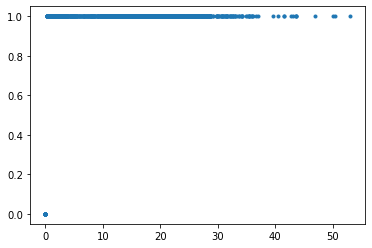

In [15]:
plt.plot(detector.pred[0], detector.target, '.')

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  2.,  1.,  2.,  0.,  0.,  2.,  0.,  1.,
         1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  3.,  1.,  0.,
         1.,  3.,  3.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  2.,
         0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  3.,
         0.,  2.,  0.,  1.,  2.,  0.,  0.,  1.,  0.,  2.,  1.,  0.,  1.,
         2.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  2.,  1.,  1.,  0.,  2.,
         0.,  1.,  0.,  2.,  0.,  3.,  1.,  1.,  1.,  3.,  1.,  3.,  1.,
         0.,  1.,  1.,  1.,  1.,  2.,  3.,  1.,  2.,  2.,  2.,  1.,  0.,
         1.,  3.,  0.,  1.,  2.,  0.,  1.,  0.,  0.,  3.,  0.,  1.,  1.,
         0.,  0.,  1.,  2.,  1.,  5.,  2.,  1.,  0.,  4.,  1.,  2.,  3.,
         0.,  1.,  0.,  1.,  1.,  2.,  1.,  4.,  0.,  0.,  3.,  0.,  1.,
         5.,  0.,  2.,  2.,  1.,  3.,  3.,  2.,  1.,  0.,  4.,  1.,  0.,
         0.,  2.,  1.,  1.,  0.,  2.,  1.,  4.,  1.

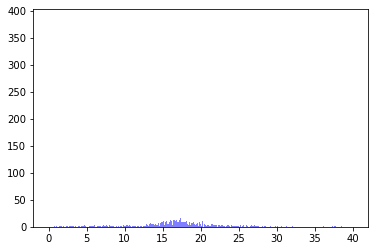

In [51]:
bins = np.linspace(0, 40, 1000)
plt.hist(detector.valid_dists.mean(1).numpy(), bins=bins, color='r', alpha=1)
plt.hist(detector.test_dists.mean(1).numpy(), bins=bins, color='b', alpha=0.5)

(array([ 4.,  1., 10., 14., 31., 46., 45., 61., 63., 43., 25., 10., 10.,
         8.,  3.,  3.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  2.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  1.]),
 array([1.2167661e-05, 3.8396247e-04, 7.5575727e-04, 1.1275520e-03,
        1.4993468e-03, 1.8711417e-03, 2.2429365e-03, 2.6147312e-03,
        2.9865261e-03, 3.3583208e-03, 3.7301157e-03, 4.1019106e-03,
        4.4737053e-03, 4.8455000e-03, 5.2172947e-03, 5.5890898e-03,
        5.9608845e-03, 6.3326792e-03, 6.7044739e-03, 7.0762690e-03,
        7.4480637e-03, 7.8198584e-03, 8.1916535e-03, 8.5634477e-03,
        8.9352429e-03, 9.3070380e-03, 9.6788323e-03, 1.0050627e-02,
        1.0422422e-02, 1.0794217e-02, 1.1166012e-02, 1.1537806e-02,
        1.1909601e-02], dtype=float32),
 <BarContainer object of 32 artists>)

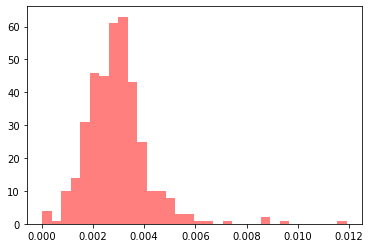

In [45]:
plt.hist(detector.valid_dists.mean(1).numpy(), bins=32, color='r', alpha=0.5)


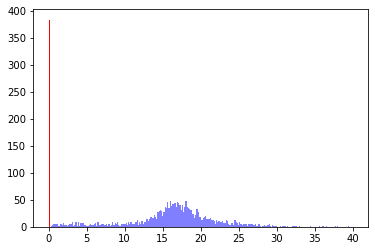

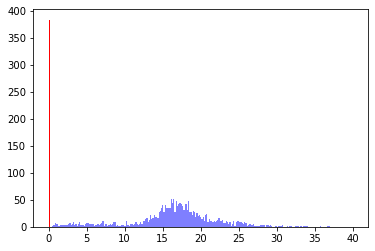

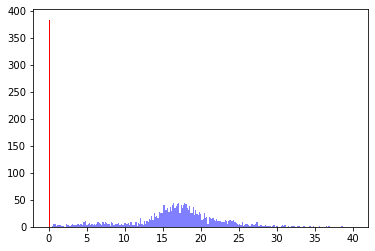

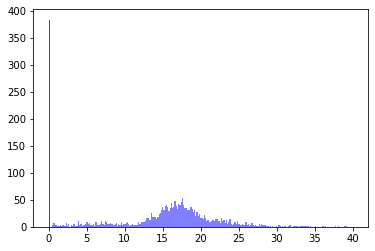

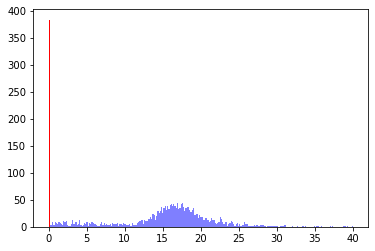

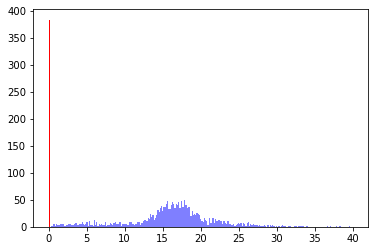

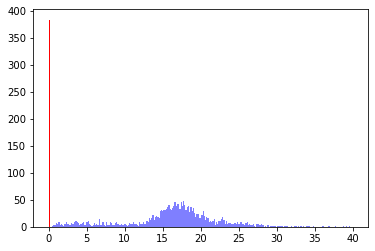

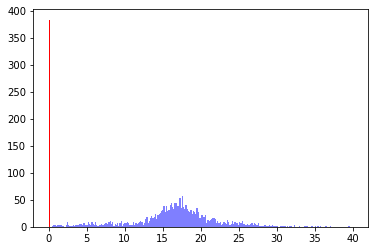

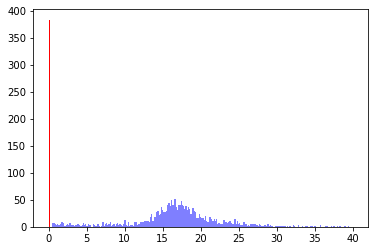

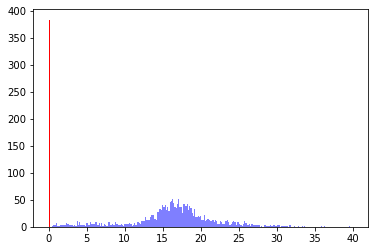

In [55]:
ensemble_compositions = torch.cat([torch.arange(10).view(10,1), 
                                                torch.randint(0, 9, (10, 4))],
                                               dim=1)
bins = np.linspace(0, 40, 250)
for i in range(10):
    plt.hist(detector.valid_dists[:, ensemble_compositions[i]].mean(1).numpy(), bins=bins, color='r', alpha=1)
    plt.hist(detector.test_dists[:, ensemble_compositions[i]].mean(1).numpy(), bins=bins, color='b', alpha=0.5)
    plt.show()

In [64]:
auroc = AUROC(task = 'binary')
for i in range(10):
    print(auroc(detector.pred[i], detector.target))

tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)


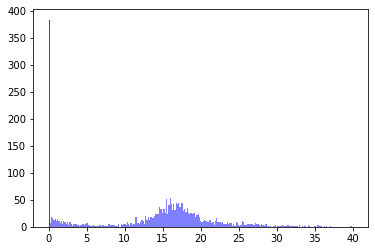

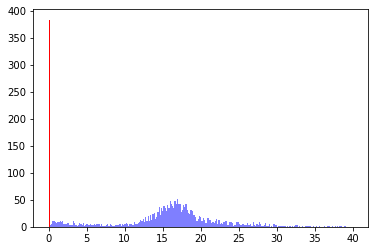

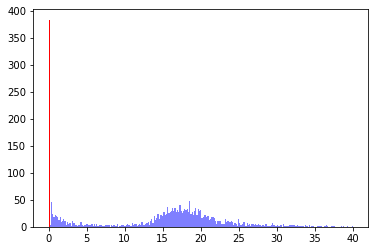

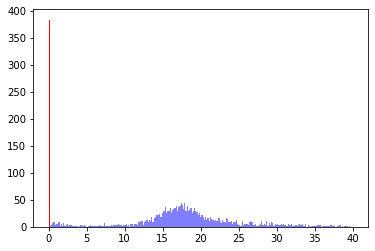

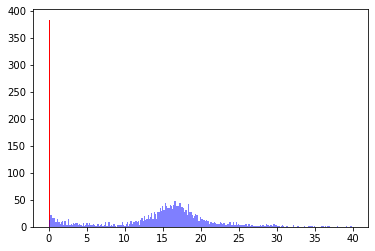

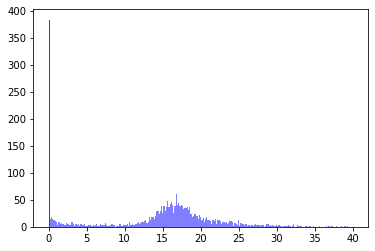

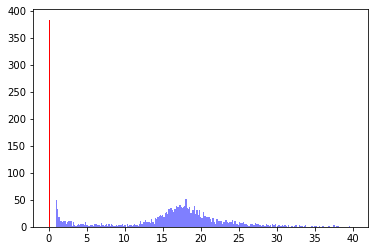

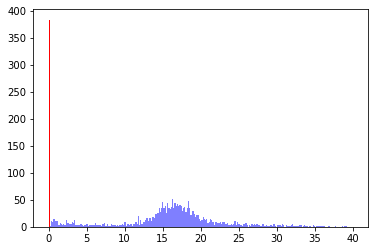

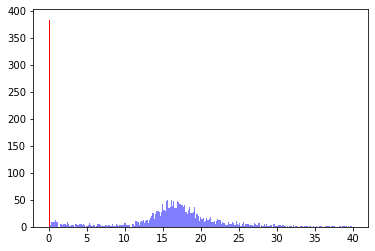

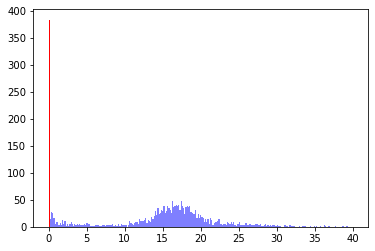

In [57]:
bins = np.linspace(0, 40, 250)
for i in range(10):
    plt.hist(detector.valid_dists[:, i].numpy(), bins=bins, color='r', alpha=1)
    plt.hist(detector.test_dists[:, i].numpy(), bins=bins, color='b', alpha=0.5)
    plt.show()

In [19]:
len(detector.test_labels)

2196

In [98]:
r = AUROC(task = 'binary', num_classes=2, average=None)
pred = torch.rand((10,10))
target = torch.ones((10,10), dtype=torch.uint8)

In [99]:
r(pred, target)

tensor([0., 0.])